In [1]:
import scvi
import anndata
import scanpy as sc
from scipy.io import mmread
import pandas as pd

C:\ProgramData\anaconda3\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\anaconda3\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\anaconda3\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\anaconda3\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\anaconda3\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing CSRDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSRDataset 

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
# Load the data into an AnnData object
# Assuming matrix.mtx contains the gene expression data, features.tsv has genes, and barcodes.tsv has cell barcodes
CO_STR_gene_expression_matrix = mmread("../../../../CO_STR.scp.raw.mtx").tocsc()  # Sparse matrix format

CO_EPI_gene_expression_matrix = mmread("../../../../CO_EPI.scp.raw.mtx").tocsc()  # Sparse matrix format

CO_IMM_gene_expression_matrix = mmread("../../../../CO_IMM.scp.raw.mtx").tocsc()  # Sparse matrix format


In [4]:
# Load gene names and cell barcodes
with open("../../../../CO_STR.scp.features.tsv") as f:
    CO_STR_gene_names = [line.strip().split()[0] for line in f]
with open("../../../../CO_STR.scp.barcodes.tsv") as f:
    CO_STR_cell_barcodes = [line.strip().split()[0] for line in f]

with open("../../../../CO_EPI.scp.features.tsv") as f:
    CO_EPI_gene_names = [line.strip().split()[0] for line in f]
with open("../../../../CO_EPI.scp.barcodes.tsv") as f:
    CO_EPI_cell_barcodes = [line.strip().split()[0] for line in f]

with open("../../../../CO_IMM.scp.features.tsv") as f:
    CO_IMM_gene_names = [line.strip().split()[0] for line in f]
with open("../../../../CO_IMM.scp.barcodes.tsv") as f:
    CO_IMM_cell_barcodes = [line.strip().split()[0] for line in f]
    
# Create the AnnData object
CO_STR_adata = anndata.AnnData(CO_STR_gene_expression_matrix.T, var={"gene_names": CO_STR_gene_names}, obs={"cell_barcodes": CO_STR_cell_barcodes})

CO_EPI_adata = anndata.AnnData(CO_EPI_gene_expression_matrix.T, var={"gene_names": CO_EPI_gene_names}, obs={"cell_barcodes": CO_EPI_cell_barcodes})

CO_IMM_adata = anndata.AnnData(CO_IMM_gene_expression_matrix.T, var={"gene_names": CO_IMM_gene_names}, obs={"cell_barcodes": CO_IMM_cell_barcodes})


In [5]:
# Load metadata containing cell type information
metadata = pd.read_csv("../../../../scp_metadata_combined.v2.txt", sep="\t")

# Set the index to match the cell barcodes in AnnData for easy mapping
metadata = metadata.set_index("NAME")

# Add cell type information to the AnnData object
CO_STR_adata.obs["Celltype"] = CO_STR_adata.obs["cell_barcodes"].map(metadata["Celltype"])
CO_EPI_adata.obs["Celltype"] = CO_EPI_adata.obs["cell_barcodes"].map(metadata["Celltype"])
CO_IMM_adata.obs["Celltype"] = CO_IMM_adata.obs["cell_barcodes"].map(metadata["Celltype"])

CO_STR_adata.obs["disease__ontology_label"] = CO_STR_adata.obs["cell_barcodes"].map(metadata["disease__ontology_label"])
CO_STR_adata.obs["donor_id"] = CO_STR_adata.obs["cell_barcodes"].map(metadata["donor_id"]).astype('category')

CO_EPI_adata.obs["disease__ontology_label"] = CO_EPI_adata.obs["cell_barcodes"].map(metadata["disease__ontology_label"])
CO_EPI_adata.obs["donor_id"] = CO_EPI_adata.obs["cell_barcodes"].map(metadata["donor_id"]).astype('category')

CO_IMM_adata.obs["disease__ontology_label"] = CO_IMM_adata.obs["cell_barcodes"].map(metadata["disease__ontology_label"])
CO_IMM_adata.obs["donor_id"] = CO_IMM_adata.obs["cell_barcodes"].map(metadata["donor_id"]).astype('category')

C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2186012359.py:2: DtypeWarning: Columns (2,3,7) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("../../../../scp_metadata_combined.v2.txt", sep="\t")


In [5]:
# Set up scVI
scvi.model.SCVI.setup_anndata(CO_STR_adata)

# Initialize the SCVI model
CO_STR_vae = scvi.model.SCVI(CO_STR_adata)

# Set workers
scvi.settings.dl_num_workers = 0 # pickle errors out if > 0
scvi.settings.dl_persistent_workers = False # iter issue if True

# Train the VAE
CO_STR_vae.train(max_epochs=400, plan_kwargs={"lr": 1e-3}, accelerator="gpu")  # Adjust epochs and learning rate as necessary

CO_STR_vae.save("CO_STR.model", overwrite=True)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [57]:
# Set up scVI
scvi.model.SCVI.setup_anndata(CO_EPI_adata)

# Initialize the SCVI model
CO_EPI_vae = scvi.model.SCVI(CO_EPI_adata)

# Set workers
scvi.settings.dl_num_workers = 0 # pickle errors out if > 0
scvi.settings.dl_persistent_workers = False # iter issue if True

# Train the VAE
CO_EPI_vae.train(max_epochs=400, plan_kwargs={"lr": 1e-3}, accelerator="gpu")  # Adjust epochs and learning rate as necessary

CO_EPI_vae.save("CO_EPI.model", overwrite=True)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [59]:
# Set up scVI
scvi.model.SCVI.setup_anndata(CO_IMM_adata)

# Initialize the SCVI model
CO_IMM_vae = scvi.model.SCVI(CO_IMM_adata)

# Set workers
scvi.settings.dl_num_workers = 0 # pickle errors out if > 0
scvi.settings.dl_persistent_workers = False # iter issue if True

# Train the VAE
CO_IMM_vae.train(max_epochs=400, plan_kwargs={"lr": 1e-3}, accelerator="gpu")  # Adjust epochs and learning rate as necessary

CO_IMM_vae.save("CO_IMM.model", overwrite=True)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [9]:
# Load model from disk
CO_STR_vae = scvi.model.SCVI.load("CO_STR.model", adata=CO_STR_adata)

INFO     File CO_STR.model\model.pt already downloaded                                                             


C:\ProgramData\anaconda3\Lib\site-packages\scvi\model\base\_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=map_lo

In [10]:
# Load model from disk
CO_EPI_vae = scvi.model.SCVI.load("CO_EPI.model", adata=CO_EPI_adata)

INFO     File CO_EPI.model\model.pt already downloaded                                                             


C:\ProgramData\anaconda3\Lib\site-packages\scvi\model\base\_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=map_lo

In [11]:
# Load model from disk
CO_IMM_vae = scvi.model.SCVI.load("CO_IMM.model", adata=CO_IMM_adata)

INFO     File CO_IMM.model\model.pt already downloaded                                                             


C:\ProgramData\anaconda3\Lib\site-packages\scvi\model\base\_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=map_lo

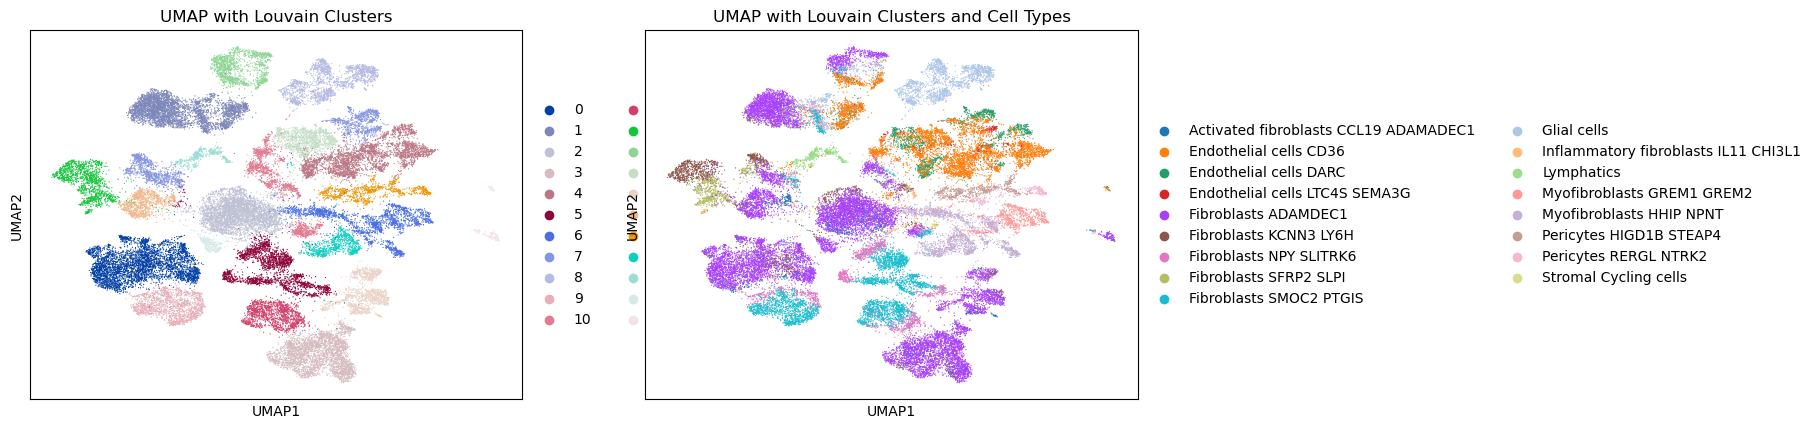

louvain
0     4002
1     3934
2     3788
3     3291
4     3071
5     2298
6     1983
7     1768
8     1752
9     1645
10    1519
11    1377
12    1346
13    1318
14    1317
15    1301
16    1020
17     944
18     844
19     458
20     295
21     162
Name: count, dtype: int64


In [18]:
# Extract the latent space representation for each cell
CO_STR_latent_representation = CO_STR_vae.get_latent_representation()
CO_STR_adata.obsm["X_scVI"] = CO_STR_latent_representation

# Use the scVI latent space to calculate neighbors
sc.pp.neighbors(CO_STR_adata, use_rep="X_scVI")

# Perform Louvain clustering
sc.tl.louvain(CO_STR_adata, resolution=0.5)  # Adjust resolution as needed

# Run UMAP based on the latent space if not already done
sc.tl.umap(CO_STR_adata)

# Plot the clusters
sc.pl.umap(CO_STR_adata, color=["louvain", "Celltype"], title=["UMAP with Louvain Clusters","UMAP with Louvain Clusters and Cell Types"])

# Access Louvain cluster labels
CO_STR_louvain_clusters = CO_STR_adata.obs["louvain"]
print(CO_STR_louvain_clusters.value_counts())


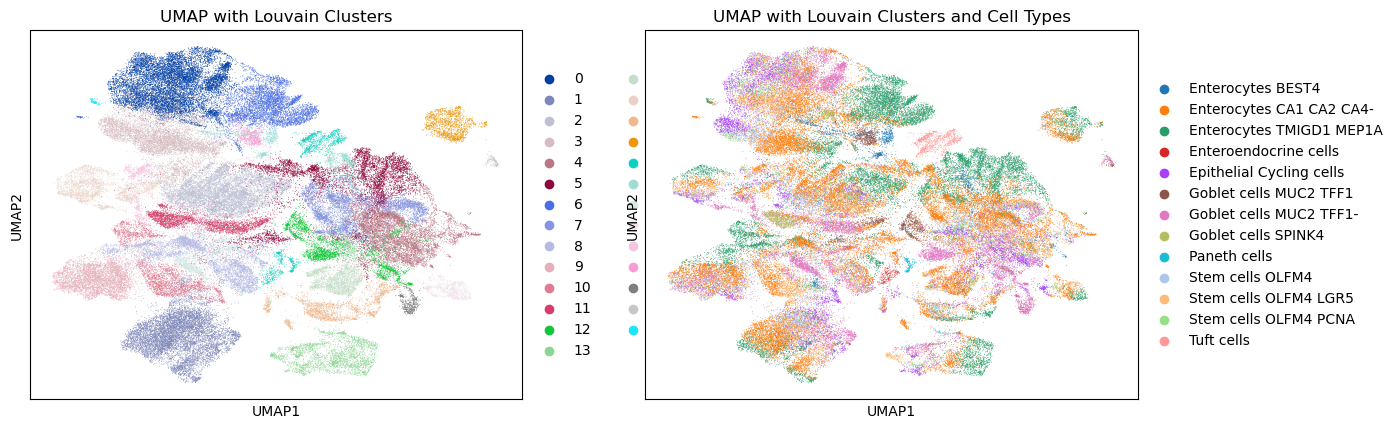

louvain
0     11036
1      8888
2      7964
3      6811
4      6746
5      6475
6      5615
7      5059
8      5048
9      4542
10     3187
11     3152
12     3056
13     2927
14     2744
15     2701
16     2433
17     1597
18     1569
19     1517
20     1407
21      924
22      852
23      692
24      573
25      160
26      113
Name: count, dtype: int64


In [19]:
# Extract the latent space representation for each cell
CO_EPI_latent_representation = CO_EPI_vae.get_latent_representation()
CO_EPI_adata.obsm["X_scVI"] = CO_EPI_latent_representation

# Use the scVI latent space to calculate neighbors
sc.pp.neighbors(CO_EPI_adata, use_rep="X_scVI")

# Perform Louvain clustering
sc.tl.louvain(CO_EPI_adata, resolution=0.5)  # Adjust resolution as needed

# Run UMAP based on the latent space if not already done
sc.tl.umap(CO_EPI_adata)

# Plot the clusters
sc.pl.umap(CO_EPI_adata, color=["louvain", "Celltype"], title=["UMAP with Louvain Clusters","UMAP with Louvain Clusters and Cell Types"])

# Access Louvain cluster labels
CO_EPI_louvain_clusters = CO_EPI_adata.obs["louvain"]
print(CO_EPI_louvain_clusters.value_counts())


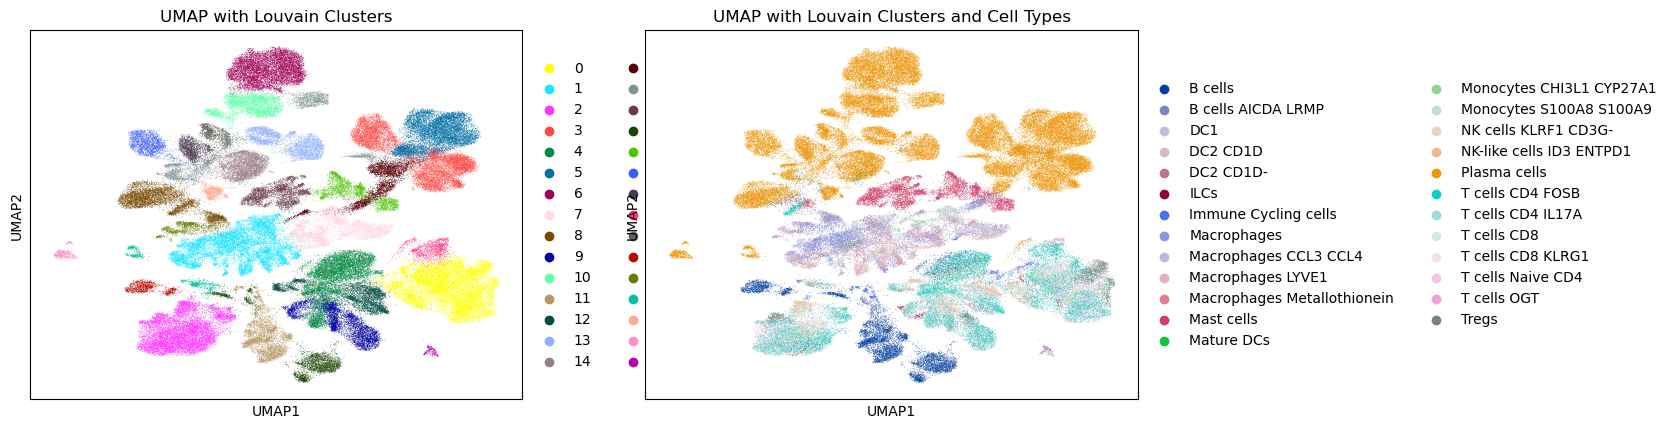

louvain
0     15520
1     13115
2     11905
3     11222
4      9906
5      9652
6      9211
7      6499
8      6123
9      5557
10     4849
11     4553
12     4432
13     4356
14     4326
15     4221
16     3779
17     3758
18     3372
19     3083
20     2364
21     1979
22     1623
23     1464
24     1284
25     1233
26     1131
27     1056
28      664
29      272
Name: count, dtype: int64


In [20]:
# Extract the latent space representation for each cell
CO_IMM_latent_representation = CO_IMM_vae.get_latent_representation()
CO_IMM_adata.obsm["X_scVI"] = CO_IMM_latent_representation

# Use the scVI latent space to calculate neighbors
sc.pp.neighbors(CO_IMM_adata, use_rep="X_scVI")

# Perform Louvain clustering
sc.tl.louvain(CO_IMM_adata, resolution=0.5)  # Adjust resolution as needed

# Run UMAP based on the latent space if not already done
sc.tl.umap(CO_IMM_adata)

# Plot the clusters
sc.pl.umap(CO_IMM_adata, color=["louvain", "Celltype"], title=["UMAP with Louvain Clusters","UMAP with Louvain Clusters and Cell Types"])

# Access Louvain cluster labels
CO_IMM_louvain_clusters = CO_IMM_adata.obs["louvain"]
print(CO_IMM_louvain_clusters.value_counts())


In [70]:
from sklearn.metrics import adjusted_rand_score
import optuna
import scvi
import scanpy as sc
import torch
import copy
import pickle

def objective(trial):
    # Create a copy of the original AnnData object for this trial
    adata = copy.deepcopy(CO_STR_adata)
    
    # Suggest hyperparameters
    latent_dim = trial.suggest_int("latent_dim", 5, 50)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    
    # Set up scVI with the suggested batch size
    scvi.model.SCVI.setup_anndata(adata)
    
    # Initialize the SCVI model with the suggested latent dimension
    vae = scvi.model.SCVI(adata, n_latent=latent_dim)
    
    # Train the model
    scvi.settings.dl_num_workers = 0  # For Windows compatibility
    scvi.settings.dl_persistent_workers = False
    vae.train(
        max_epochs=100,
        plan_kwargs={"lr": lr},
        accelerator="gpu",
        early_stopping=True,
        early_stopping_monitor="elbo_train",  # Monitor evidence lower bound
        early_stopping_patience=10  # Stop if no improvement after 10 epochs
    )
    # Evaluate clustering quality using Adjusted Rand Index (ARI)
    adata.uns.pop("neighbors", None)  # Reset neighbors
    adata.obsm.pop("X_umap", None)  # Reset UMAP if it exists
    latent = vae.get_latent_representation()
    adata.obsm["X_scVI"] = latent
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.louvain(adata, resolution=0.5)
    
    # Drop NaN values for ARI calculation
    valid_cells = ~adata.obs["Celltype"].isna()
    ari = adjusted_rand_score(
        adata.obs["Celltype"][valid_cells],
        adata.obs["louvain"][valid_cells]
    )
    
    return ari  # Maximize ARI


# Run the hyperparameter optimization
CO_STR_study = optuna.create_study(direction="maximize")
CO_STR_study.optimize(objective, n_trials=20)  # Adjust the number of trials

# Print the best hyperparameters
best_params = CO_STR_study.best_params
print("Best hyperparameters:", best_params)

# Save the study to a pickle file
with open("CO_STR_study.pkl", "wb") as f:
    pickle.dump(CO_STR_study, f)

# Set up scVI with the suggested batch size
scvi.model.SCVI.setup_anndata(CO_STR_adata)

# Train the final model with the best parameters
CO_STR_tuned_vae = scvi.model.SCVI(CO_STR_adata, n_latent=best_params["latent_dim"])
CO_STR_tuned_vae.train(
    max_epochs=400,
    plan_kwargs={"lr": best_params["lr"]},
    accelerator="gpu"
)
CO_STR_tuned_vae.save("CO_STR_tuned.model", overwrite=True)


Best hyperparameters: {'latent_dim': 5, 'lr': 0.0001184620238284258}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [6]:
from sklearn.metrics import adjusted_rand_score
import optuna
import scvi
import scanpy as sc
import torch
import copy
import pickle

def objective(trial):
    # Create a copy of the original AnnData object for this trial
    adata = CO_EPI_adata
    
    # Suggest hyperparameters
    latent_dim = trial.suggest_int("latent_dim", 5, 50)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    
    # Set up scVI with the suggested batch size
    scvi.model.SCVI.setup_anndata(adata)
    
    # Initialize the SCVI model with the suggested latent dimension
    vae = scvi.model.SCVI(adata, n_latent=latent_dim)
    
    # Train the model
    scvi.settings.dl_num_workers = 0  # For Windows compatibility
    scvi.settings.dl_persistent_workers = False
    vae.train(
        max_epochs=100,
        plan_kwargs={"lr": lr},
        accelerator="gpu",
        early_stopping=True,
        early_stopping_monitor="elbo_train",  # Monitor evidence lower bound
        early_stopping_patience=10  # Stop if no improvement after 10 epochs
    )
    # Evaluate clustering quality using Adjusted Rand Index (ARI)
    adata.uns.pop("neighbors", None)  # Reset neighbors
    adata.obsm.pop("X_umap", None)  # Reset UMAP if it exists
    latent = vae.get_latent_representation()
    adata.obsm["X_scVI"] = latent
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.louvain(adata, resolution=0.5)
    
    # Drop NaN values for ARI calculation
    valid_cells = ~adata.obs["Celltype"].isna()
    ari = adjusted_rand_score(
        adata.obs["Celltype"][valid_cells],
        adata.obs["louvain"][valid_cells]
    )
    
    return ari  # Maximize ARI


# Run the hyperparameter optimization
CO_EPI_study = optuna.create_study(direction="maximize")
CO_EPI_study.optimize(objective, n_trials=20)  # Adjust the number of trials

# Print the best hyperparameters
best_params = CO_EPI_study.best_params
print("Best hyperparameters:", best_params)

# Save the study to a pickle file
with open("CO_EPI_study.pkl", "wb") as f:
    pickle.dump(CO_EPI_study, f)

# Set up scVI with the suggested batch size
scvi.model.SCVI.setup_anndata(CO_EPI_adata)

# Train the final model with the best parameters
CO_EPI_tuned_vae = scvi.model.SCVI(CO_EPI_adata, n_latent=best_params["latent_dim"])
CO_EPI_tuned_vae.train(
    max_epochs=400,
    plan_kwargs={"lr": best_params["lr"]},
    accelerator="gpu"
)
CO_EPI_tuned_vae.save("CO_EPI_tuned.model", overwrite=True)


[I 2024-11-18 16:10:41,911] A new study created in memory with name: no-name-52825a98-c4f1-4eca-a187-49e4634ef40b
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-18 16:49:08,063] Trial 0 finished with value: 0.04815106291670558 and parameters: {'latent_dim': 19, 'lr': 0.00019367459659743957}. Best is trial 0 with value: 0.04815106291670558.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-18 17:25:16,703] Trial 1 finished with value: 0.046846186007956814 and parameters: {'latent_dim': 13, 'lr': 0.006709322047258047}. Best is trial 0 with value: 0.04815106291670558.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader`

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-18 18:03:29,402] Trial 2 finished with value: 0.037642229905056016 and parameters: {'latent_dim': 39, 'lr': 0.000628816640253706}. Best is trial 0 with value: 0.04815106291670558.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader`

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-18 18:40:24,840] Trial 3 finished with value: 0.07296494132503611 and parameters: {'latent_dim': 5, 'lr': 0.0003806433651450257}. Best is trial 3 with value: 0.07296494132503611.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` 

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-18 19:17:17,136] Trial 4 finished with value: 0.04255939438294196 and parameters: {'latent_dim': 18, 'lr': 0.0019663300834318782}. Best is trial 3 with value: 0.07296494132503611.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader`

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-18 19:51:05,269] Trial 5 finished with value: 0.04853253552768227 and parameters: {'latent_dim': 21, 'lr': 0.00013188763969330038}. Best is trial 3 with value: 0.07296494132503611.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-18 20:25:55,492] Trial 6 finished with value: 0.04592447837208841 and parameters: {'latent_dim': 24, 'lr': 0.00012048498300971732}. Best is trial 3 with value: 0.07296494132503611.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-18 20:59:40,100] Trial 7 finished with value: 0.039167234166165826 and parameters: {'latent_dim': 30, 'lr': 0.0007662429978276944}. Best is trial 3 with value: 0.07296494132503611.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-18 21:35:36,161] Trial 8 finished with value: 0.04921864202148784 and parameters: {'latent_dim': 18, 'lr': 0.00034231399338880233}. Best is trial 3 with value: 0.07296494132503611.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-18 22:11:08,240] Trial 9 finished with value: 0.0739370257653317 and parameters: {'latent_dim': 8, 'lr': 0.004728305596398841}. Best is trial 9 with value: 0.0739370257653317.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to 

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-18 22:48:31,562] Trial 10 finished with value: 0.03726651130113102 and parameters: {'latent_dim': 48, 'lr': 0.005962148087284588}. Best is trial 9 with value: 0.0739370257653317.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` 

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-18 23:25:24,642] Trial 11 finished with value: 0.0842785658599632 and parameters: {'latent_dim': 5, 'lr': 0.00257711142819166}. Best is trial 11 with value: 0.0842785658599632.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-19 00:06:32,317] Trial 12 finished with value: 0.06244045319332984 and parameters: {'latent_dim': 7, 'lr': 0.0023894866028325206}. Best is trial 11 with value: 0.0842785658599632.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader`

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-19 00:42:09,842] Trial 13 finished with value: 0.04630624634767503 and parameters: {'latent_dim': 11, 'lr': 0.00269552475275595}. Best is trial 11 with value: 0.0842785658599632.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` 

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-19 01:17:05,775] Trial 14 finished with value: 0.03617803683738487 and parameters: {'latent_dim': 31, 'lr': 0.0040179201034489815}. Best is trial 11 with value: 0.0842785658599632.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-19 01:52:29,699] Trial 15 finished with value: 0.04909756018305094 and parameters: {'latent_dim': 11, 'lr': 0.001336583064286941}. Best is trial 11 with value: 0.0842785658599632.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader`

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-19 02:27:05,900] Trial 16 finished with value: 0.044942446534809034 and parameters: {'latent_dim': 6, 'lr': 0.009426038654454473}. Best is trial 11 with value: 0.0842785658599632.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader`

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-19 03:00:40,338] Trial 17 finished with value: 0.04779645530366557 and parameters: {'latent_dim': 14, 'lr': 0.0043852195058471585}. Best is trial 11 with value: 0.0842785658599632.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-19 03:34:17,577] Trial 18 finished with value: 0.03585673655169306 and parameters: {'latent_dim': 36, 'lr': 0.0013571305190618478}. Best is trial 11 with value: 0.0842785658599632.
C:\Users\Chan_\AppData\Local\Temp\ipykernel_27284\2954744319.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
[I 2024-11-19 04:07:54,559] Trial 19 finished with value: 0.036525804197020124 and parameters: {'latent_dim': 25, 'lr': 0.004117550096011832}. Best is trial 11 with value: 0.0842785658599632.


Best hyperparameters: {'latent_dim': 5, 'lr': 0.00257711142819166}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [40]:
import pickle

# Load the study from the pickle file
with open("CO_STR_study.pkl", "rb") as f:
    CO_STR_study = pickle.load(f)


In [13]:
# Load model from disk
CO_STR_tuned_vae = scvi.model.SCVI.load("CO_STR_tuned.model", adata=CO_STR_adata)

INFO     File CO_STR_tuned.model\model.pt already downloaded                                                       


C:\ProgramData\anaconda3\Lib\site-packages\scvi\model\base\_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=map_lo

In [ ]:
import pickle

# Load the study from the pickle file
with open("CO_EPI_study.pkl", "rb") as f:
    CO_EPI_study = pickle.load(f)


In [ ]:
# Load model from disk
CO_EPI_tuned_vae = scvi.model.SCVI.load("CO_EPI_tuned.model", adata=CO_EPI_adata)

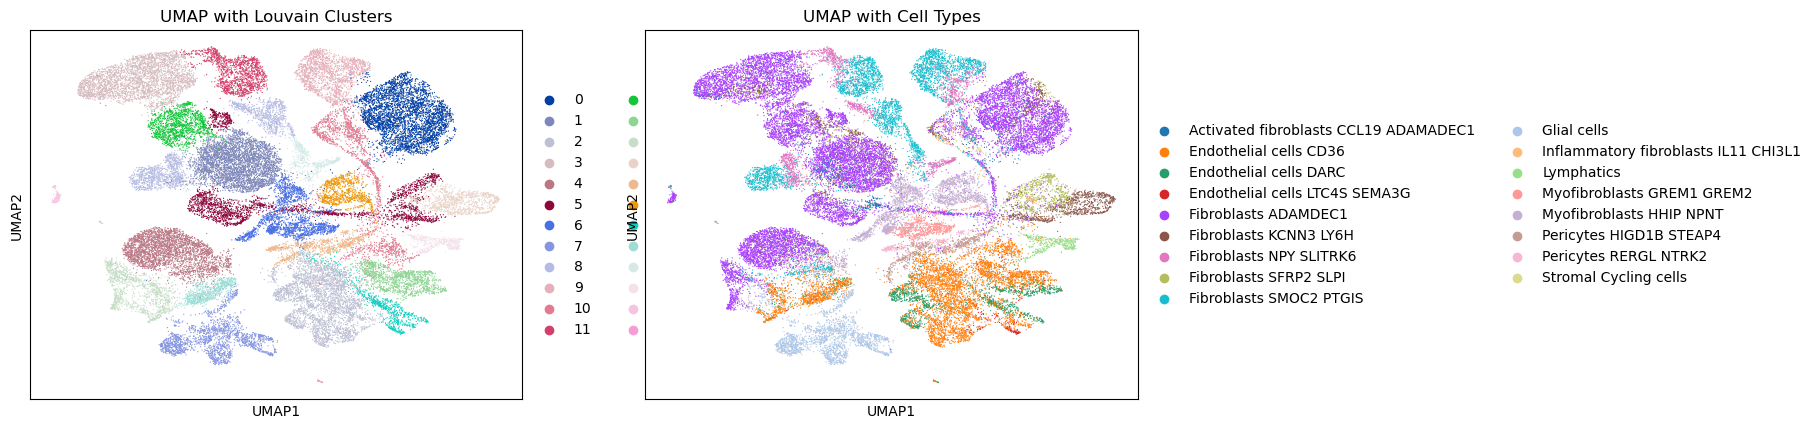

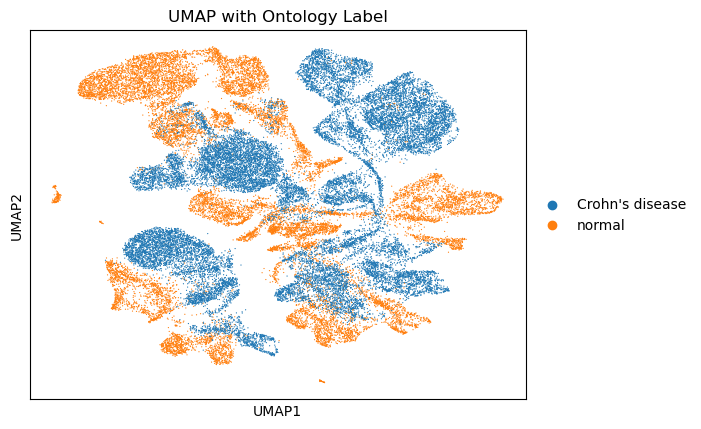

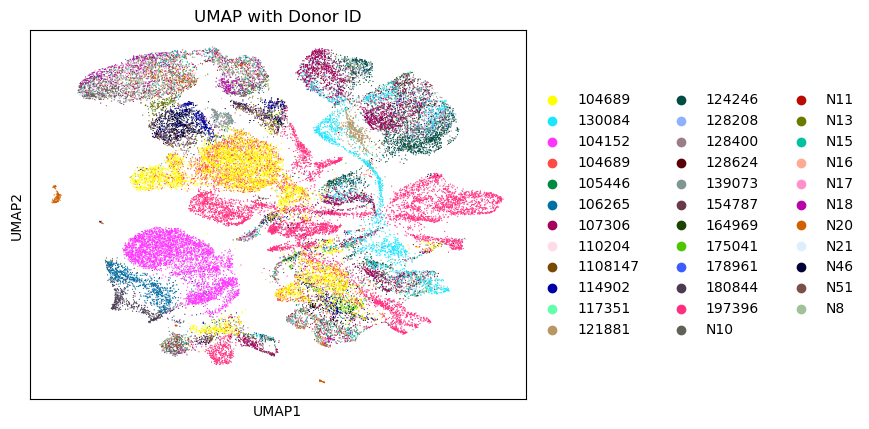

In [17]:
# Extract the latent space representation for each cell
CO_STR_latent_representation = CO_STR_tuned_vae.get_latent_representation()
CO_STR_adata.obsm["X_scVI"] = CO_STR_latent_representation

# Use the scVI latent space to calculate neighbors
sc.pp.neighbors(CO_STR_adata, use_rep="X_scVI")

# Perform Louvain clustering
sc.tl.louvain(CO_STR_adata, resolution=0.5)  # Adjust resolution as needed

# Run UMAP based on the latent space if not already done
sc.tl.umap(CO_STR_adata)

# Plot the clusters
sc.pl.umap(CO_STR_adata, color=["louvain", "Celltype"], title=["UMAP with Louvain Clusters","UMAP with Cell Types"])

# Plot the clusters
sc.pl.umap(CO_STR_adata, color="disease__ontology_label", title="UMAP with Ontology Label")
sc.pl.umap(CO_STR_adata, color="donor_id", title="UMAP with Donor ID")



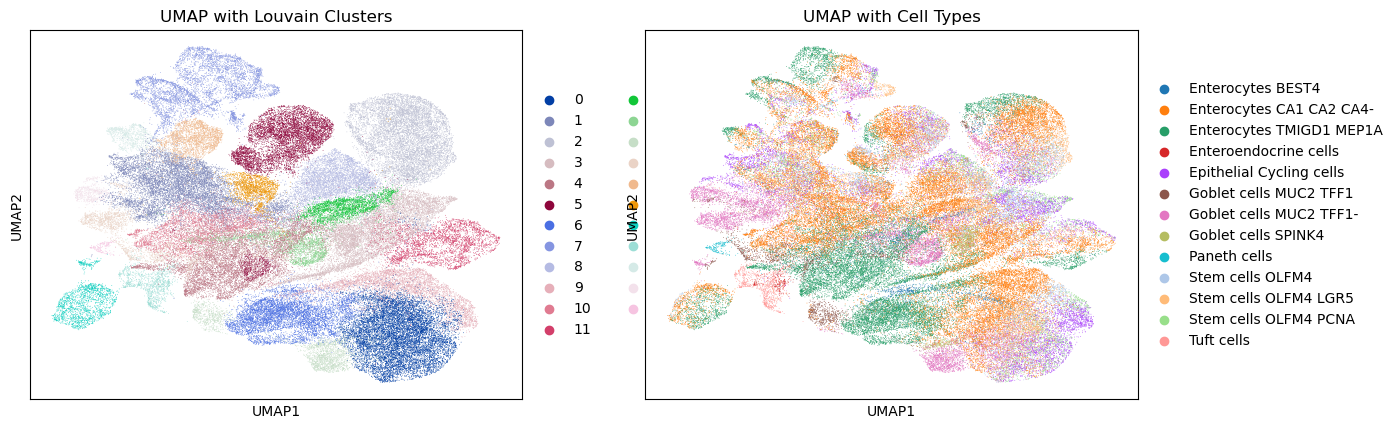

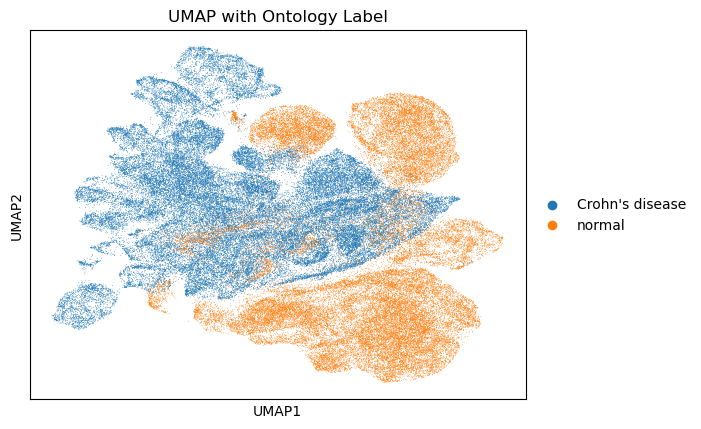

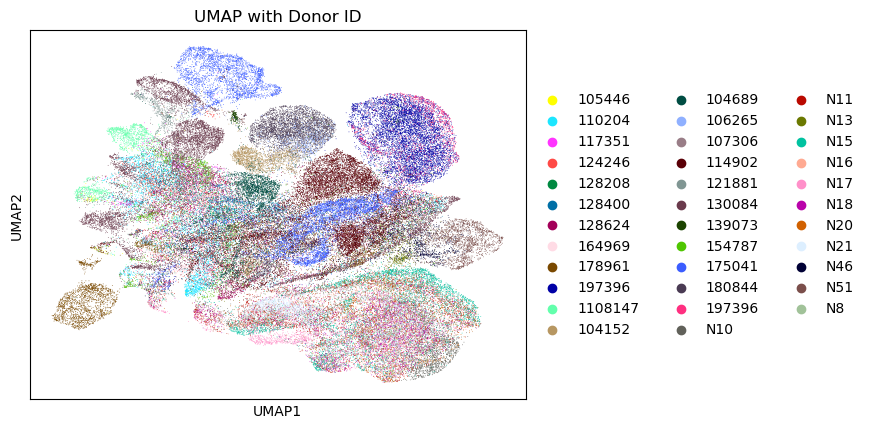

In [11]:
# Extract the latent space representation for each cell
CO_EPI_latent_representation = CO_EPI_tuned_vae.get_latent_representation()
CO_EPI_adata.obsm["X_scVI"] = CO_EPI_latent_representation

# Use the scVI latent space to calculate neighbors
sc.pp.neighbors(CO_EPI_adata, use_rep="X_scVI")

# Perform Louvain clustering
sc.tl.louvain(CO_EPI_adata, resolution=0.5)  # Adjust resolution as needed

# Run UMAP based on the latent space if not already done
sc.tl.umap(CO_EPI_adata)

# Plot the clusters
sc.pl.umap(CO_EPI_adata, color=["louvain", "Celltype"], title=["UMAP with Louvain Clusters","UMAP with Cell Types"])

# Plot the clusters
sc.pl.umap(CO_EPI_adata, color="disease__ontology_label", title="UMAP with Ontology Label")
sc.pl.umap(CO_EPI_adata, color="donor_id", title="UMAP with Donor ID")



INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


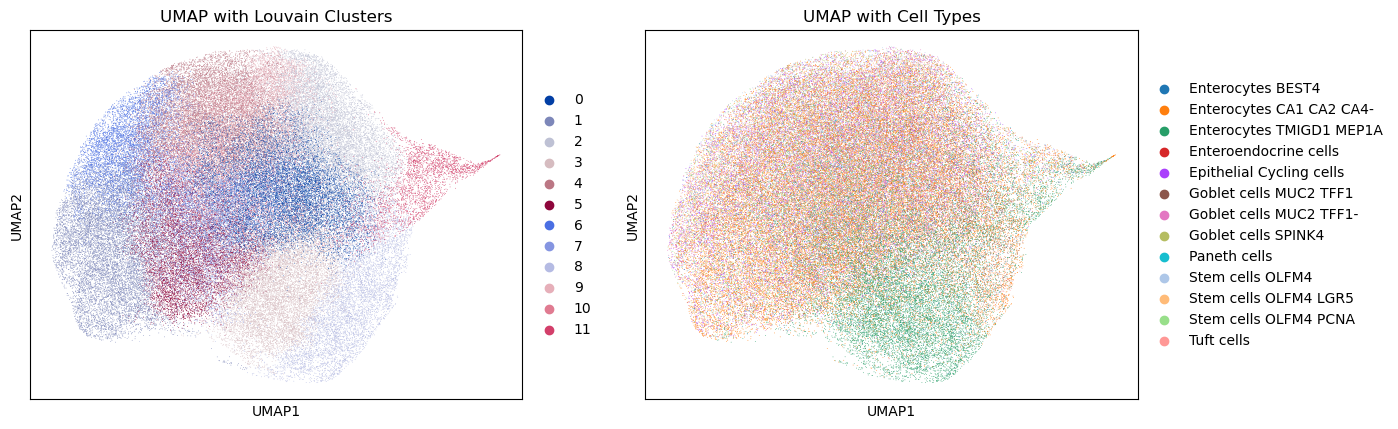

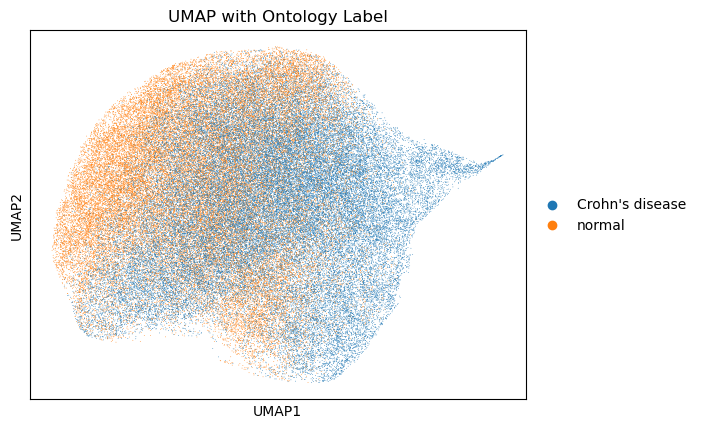

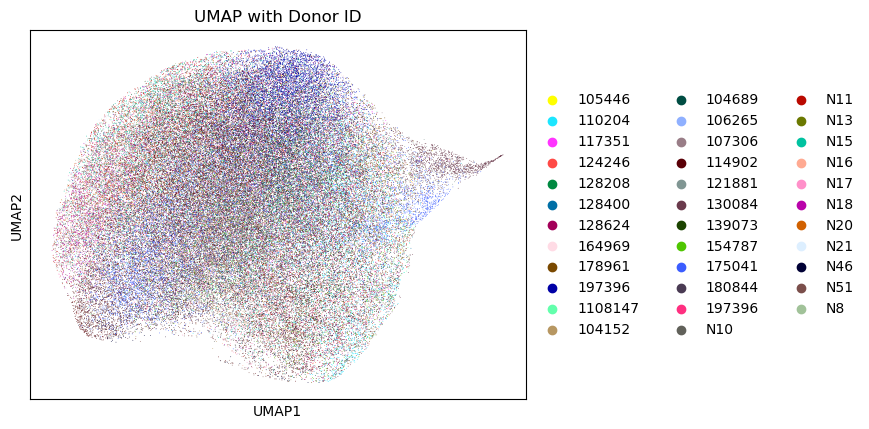

In [15]:
# Extract the latent space representation for CO_EPI cells
CO_EPI_latent_representation = CO_STR_tuned_vae.get_latent_representation(CO_EPI_adata)
CO_EPI_adata.obsm["X_scVI"] = CO_EPI_latent_representation

# Use the scVI latent space to calculate neighbors
sc.pp.neighbors(CO_EPI_adata, use_rep="X_scVI")

# Perform Louvain clustering
sc.tl.louvain(CO_EPI_adata, resolution=0.5)  # Adjust resolution as needed

# Run UMAP based on the latent space if not already done
sc.tl.umap(CO_EPI_adata)

# Plot the clusters
sc.pl.umap(CO_EPI_adata, color=["louvain", "Celltype"], title=["UMAP with Louvain Clusters","UMAP with Cell Types"])

# Plot the clusters
sc.pl.umap(CO_EPI_adata, color="disease__ontology_label", title="UMAP with Ontology Label")
sc.pl.umap(CO_EPI_adata, color="donor_id", title="UMAP with Donor ID")



INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


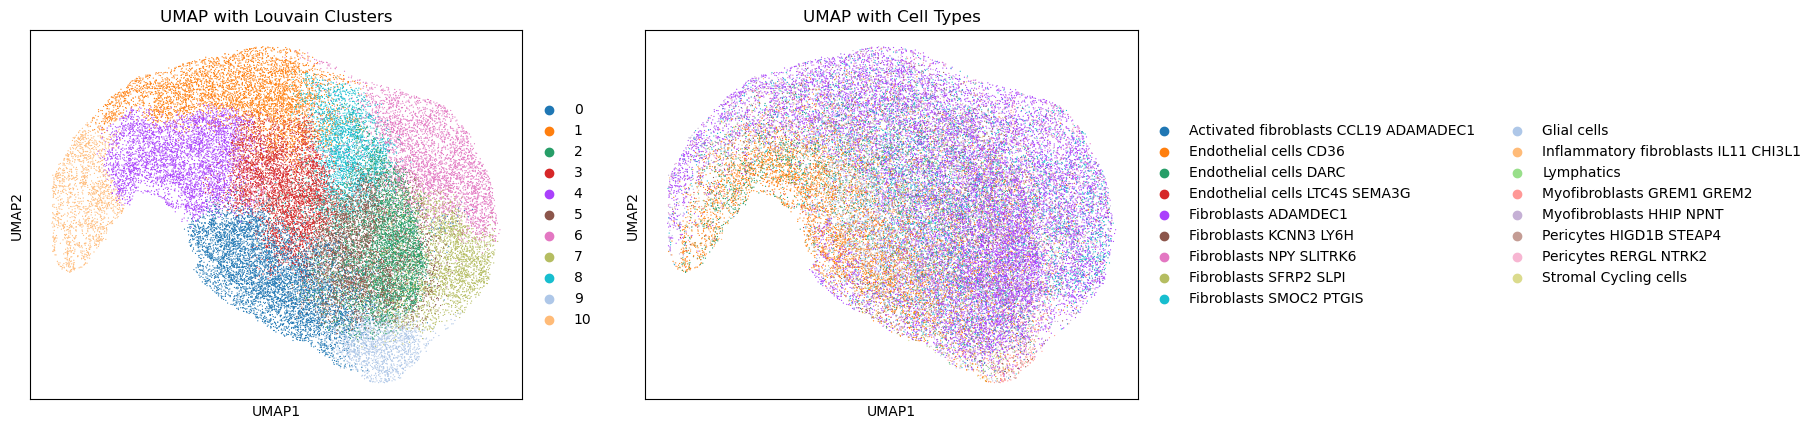

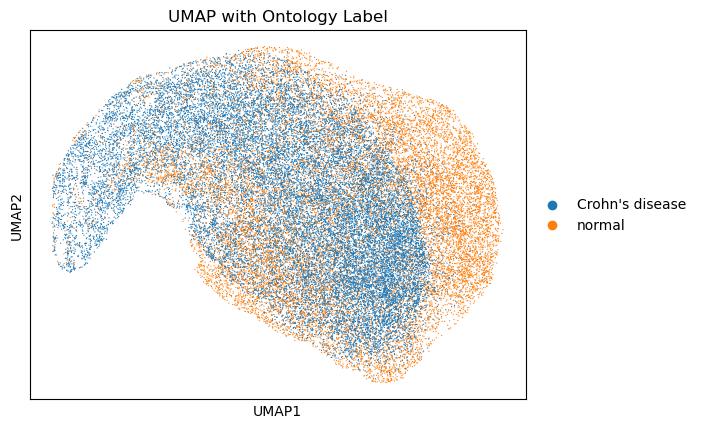

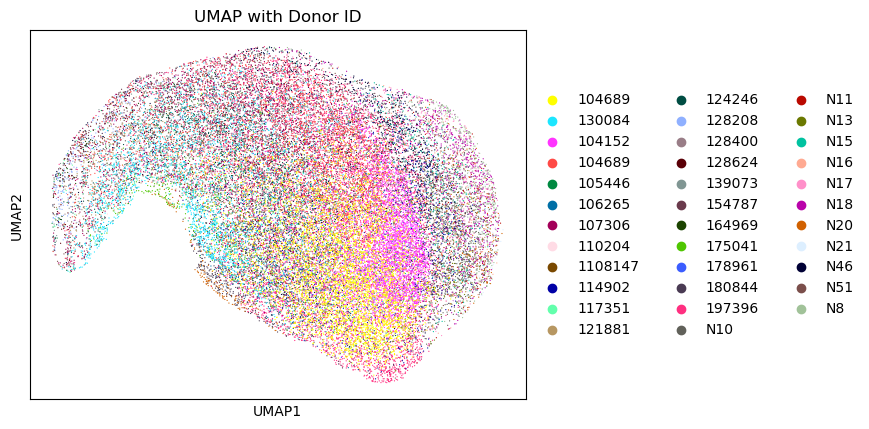

In [16]:
# Extract the latent space representation for CO_EPI cells
CO_STR_latent_representation = CO_EPI_tuned_vae.get_latent_representation(CO_STR_adata)
CO_STR_adata.obsm["X_scVI"] = CO_STR_latent_representation

# Use the scVI latent space to calculate neighbors
sc.pp.neighbors(CO_STR_adata, use_rep="X_scVI")

# Perform Louvain clustering
sc.tl.louvain(CO_STR_adata, resolution=0.5)  # Adjust resolution as needed

# Run UMAP based on the latent space if not already done
sc.tl.umap(CO_STR_adata)

# Plot the clusters
sc.pl.umap(CO_STR_adata, color=["louvain", "Celltype"], title=["UMAP with Louvain Clusters","UMAP with Cell Types"])

# Plot the clusters
sc.pl.umap(CO_STR_adata, color="disease__ontology_label", title="UMAP with Ontology Label")
sc.pl.umap(CO_STR_adata, color="donor_id", title="UMAP with Donor ID")

